# Explanations Stability

In this notebook we will explore how to calculate the stability of an local explanation for the Partial Effects explainer. We'll first start creating a classifier and fitting it with the iris data set. Then, we'll define the stability metric function and see how stable are the explanations.

In this notebook we will use the definition of stability given in: _____

In [1]:
import numpy  as np
import pandas as pd

# automatically differentiable implementation of numpy
import jax.numpy as jnp

from sklearn import datasets
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from IPython.display         import display, Math, Latex

import matplotlib.pyplot as plt

from itea.classification import ITEA_classifier
from itea.inspection     import *

import warnings; warnings.filterwarnings('ignore')

In [2]:
iris_data = datasets.load_iris()
X, y      = iris_data['data'], iris_data['target']
labels    = iris_data['feature_names']
targets   = iris_data['target_names']

# changing numbers to the class names
y_targets = [targets[yi] for yi in y]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_targets, test_size=0.33, random_state=42)

# Creating transformation functions for ITEA using jax.numpy
# (so we don't need to analytically calculate its derivatives)
tfuncs = {
    'id'       : lambda x: x,
    'sqrt.abs' : lambda x: jnp.sqrt(jnp.abs(x)), 
    'log'      : jnp.log,
    'sin'      : jnp.sin,
    'cos'      : jnp.cos,
    'exp'      : jnp.exp
}

clf = ITEA_classifier(
    gens            = 50,
    popsize         = 50,
    max_terms       = 3,
    expolim         = (-2, -2),
    verbose         = 5,
    tfuncs          = tfuncs,
    labels          = labels,
    simplify_method = 'simplify_by_var',
    random_state    = 42,
).fit(X_train, y_train)

gen 	 min_fitness 	 mean_fitness 	 max_fitness 	 remaining (s)
0 	 0.37 	 0.7465999999999999 	 0.93 	 0min40seg
5 	 0.93 	 0.93 	 0.93 	 0min49seg
10 	 0.93 	 0.93 	 0.93 	 0min44seg
15 	 0.93 	 0.93 	 0.93 	 0min37seg
20 	 0.93 	 0.93 	 0.93 	 0min32seg
25 	 0.93 	 0.93 	 0.93 	 0min26seg
30 	 0.93 	 0.93 	 0.93 	 0min21seg
35 	 0.93 	 0.93 	 0.93 	 0min16seg
40 	 0.93 	 0.93 	 0.93 	 0min10seg
45 	 0.93 	 0.93 	 0.93 	 0min5seg


## Local explanations with the Partial Effects

To calculate the local explanations, we can use the function ``ITExpr_explainer.average_partial_effects``, passing as argument a single sample we want to explain.

We can see the explanation both visually or as an array with the importance for each feature.

Lets start by creating an explainer instance.

In [3]:
explainer = ITExpr_explainer(
    itexpr=clf.bestsol_,
    tfuncs=tfuncs
).fit(X_train, y_train)

The visual inspection of feature importances can be useful in some cases:
* The features are ordered by the most important to the least important feature;
* The proportions between feature importances allows to have a more clear understanding about its magnitudes;
* We can see how much each class is using each feature to make its classification.

It is important to notice that the prediction of the model is based on the class with highest probability from the decision function. The decision function is a logit function using the IT expression as its linear model.

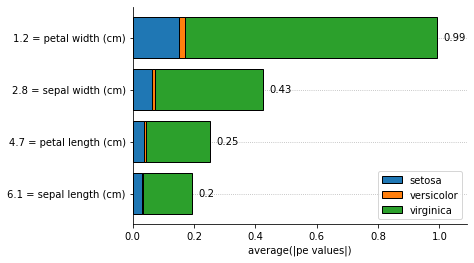

In [4]:
explainer.plot_feature_importances(
    X = X_test[0, :].reshape(1, -1),
    importance_method = 'pe',
    grouping_threshold = 0.0,
    target = None,
    barh_kw = {'edgecolor' : 'k'},
    show = True
)

In [5]:
explainer.average_partial_effects(X_test[0, :].reshape(1, -1))

array([[0.02966762, 0.06463303, 0.03850478, 0.1508104 ],
       [0.00392922, 0.00856008, 0.00509962, 0.01997353],
       [0.16151722, 0.35187682, 0.20962874, 0.82104593]])

The function returns an array, where each line corresponds to the importance for each class. As we can see from the bar plot, the total importance for a given feature is the summation of the importance for each class:

In [6]:
np.sum(
    explainer.average_partial_effects(X_test[0, :].reshape(1, -1)),
    axis=0
)

array([0.19511406, 0.42506993, 0.25323315, 0.99182986])

Creating the stability function. We'll make some modifications.

In [7]:
def explain_single(x):
    return np.sum(
        explainer.average_partial_effects(x.reshape(1, -1)),
        axis=0
    )


def norm_p2(vector):
    return np.sqrt(np.sum(np.abs(np.power(vector, 2))))


def stability(explainer, x, neighborhood):
    
    return np.mean([
        norm_p2(explainer(nb) - explainer(x))**2 for nb in neighborhood
    ])
        
    
def neighborhood(x, factor, size=100):
    cov = np.cov(X_train.T)

    return np.random.multivariate_normal(x, cov*factor, size=size)


stability(
    explain_single,
    X_test[0],
    neighborhood(X_test[0], 0.001)
)

0.005655794080951104

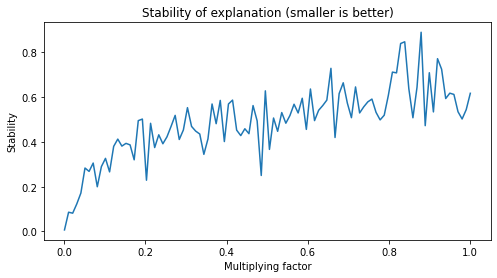

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(8,4))

factors = np.linspace(0.001, 1, 100)

axs.plot(
    factors,
    [stability(
        explain_single,
        X_test[0],
        neighborhood(X_test[0], factor, size=20)
    ) for factor in factors]
)

axs.set_title("Stability of explanation (smaller is better)")
axs.set_ylabel("Stability")
axs.set_xlabel("Multiplying factor")

plt.show()